<a href="https://colab.research.google.com/github/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## References 

 * Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
 * Sample/starter code: https://github.com/Nir-J/ML-Projects/blob/master/UNSW-Network_Packet_Classification/unsw.py

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

Using TensorFlow backend.


# Preprocessing (transformation/scaling) 

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [3]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test contamination ", round(len(tmp)/len(test),2),'\n')

if contamination > 0.5:
  print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
  contamination = 1-contamination
print(f'contamination is {contamination}')

train contamination  0.32
test contamination  0.45 

contamination is 0.32


In [4]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")
print("looks like 6 is 'normal', but its not that common") 

attack cat: {'Worms', 'Shellcode', 'Generic', 'Backdoor', 'Normal', 'Fuzzers', 'Reconnaissance', 'Analysis', 'Exploits', 'DoS'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32
mode 0.3609225646458884 %
looks like 6 is 'normal', but its not that common


In [5]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [6]:
combined_data.head(3)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,6,0


In [7]:
data_x = combined_data.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data.loc[:,['label']]
# del combined_data # free mem
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.50, random_state=42) # TODO

In [8]:
X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(128836, 42)

(128836, 1)

(128837, 42)

(128837, 1)

# Benchmark

In [ ]:
DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500) # multiclass

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.92544 for the DecisionTreeClassifier
Acc: 0.94138 for the RandomForestClassifier
Acc: 0.94051 for the ExtraTreesClassifier
Acc: 0.93472 for the XGBClassifier
Acc: 0.94362 for the LGBMClassifier


In [ ]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))


pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
plt.show()

Acc: 0.94141 for the EnsembleVoteClassifier


## Unsupervied ML

In [ ]:
%%capture 
!pip install pyod
!pip install hdbscan
!pip install rrcf
!pip install combo
!pip install SOM...... # https://github.com/AICoE/log-anomaly-detector/blob/master/Notebooks/SOM_retrain_notebook/SOM_UserFeedbackPOC.ipynb
!pip install somtf

In [ ]:
import gc, os, pickle
from datetime import datetime

import numpy as np
import pandas as pd
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyod
from hdbscan import HDBSCAN
import rrcf

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.svm import *

In [ ]:
from pyod.models import lof, cblof, cof, pca, iforest, knn, mcd, ocsvm, sod, abod, hbos #, auto_encoder, vae
contamination = 0.01
threshold = 0.75

In [ ]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test contamination ", round(len(tmp)/len(test),2),'\n')

if contamination > 0.5:
  print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
  contamination = 1-contamination
print(f'contamination is {contamination}')

ratio of normal in train  0.32
contamination in train  0.68
ratio of normal in test  0.45 

contamination is 0.68, which is greater than 0.5. Fixing...
contamination is 0.32


## Uses PYOD

In [ ]:
lof_clf = lof.LOF(contamination=contamination, n_jobs=-1)
_ = lof_clf.fit(X_train)

predictions = lof_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = lof_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

Acc of train: 0.5108278030038421
Acc of test: 0.5212162666938328


In [ ]:
cblof_clf = cblof.CBLOF(contamination=contamination, n_jobs=-1, n_clusters=45)
_ = cblof_clf.fit(X_train)

predictions = cblof_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = cblof_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

Acc of train: 0.3870842550549152
Acc of test: 0.3908430719077904


In [ ]:
cof_clf = cof.COF(contamination=contamination) # slow and mem intensive 10,000 soft limit 
_ = cof_clf.fit(X_train[:1000])

predictions = cof_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = cof_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

In [ ]:
# https://pyod.readthedocs.io/en/latest/_modules/pyod/models/pca.html
pca_clf = pca.PCA(contamination=contamination)
_ = pca_clf.fit(X_train)

predictions = pca_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = pca_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

PCA(contamination=0.32, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

Acc of train: 0.43190903093103583
Acc of test: 0.43209678905980914


In [ ]:
iforest_clf = iforest.IForest(contamination=contamination, n_estimators=300, max_samples= 1028, n_jobs=-1)
_ = iforest_clf.fit(X_train)

predictions = iforest_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = iforest_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

Acc of train: 0.34641207746342223
Acc of test: 0.3474888303523351


In [ ]:
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(X_train)

predictions = knn_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = knn_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

Acc of train: 0.4621026894865526
Acc of test: 0.46278967104720603


In [ ]:
ocsvm_clf = ocsvm.OCSVM(contamination=contamination) # expensive? 
_ = ocsvm_clf.fit(X_train[:1000])

predictions = ocsvm_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = ocsvm_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

Acc of train: 0.5762991423138123
Acc of test: 0.5783427687143141


In [ ]:
X_temp = X_train.astype(np.float) 
abod_clf = abod.ABOD(contamination=contamination, n_neighbors=10, )
_ = abod_clf.fit(X_temp)


predictions = abod_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = abod_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

Acc of train: 0.3617999767144021
Acc of test: 0.3607032148210673


In [ ]:
hdbScan_clf = HDBSCAN(15, leaf_size=80)
_ = hdbScan_clf.fit(X_train)

hdbScan_clf_outliers = hdbScan_clf.outlier_scores_ > 0.05 # akin to clf.pred_proba 

print(round(sum(hdbScan_clf_outliers == True)/X_train.shape[0], 5),"% outliers")
# pd.DataFrame(X_train[hdbScan_clf_outliers])
accuracy_score(y_train, hdbScan_clf_outliers)

0.41491 % outliers


0.4813327123840571

In [ ]:
from suod.models.base import SUOD

# initialize a set of base outlier detectors to train and predict on
base_estimators = [
    knn.KNN(n_neighbors=5,  contamination=contamination, radius=1.5),
    knn.KNN(n_neighbors=15, contamination=contamination, radius=1.5),
    knn.KNN(n_neighbors=25, contamination=contamination, radius=1.5),
    lof.LOF(n_neighbors=5,  contamination=contamination),
    lof.LOF(n_neighbors=15, contamination=contamination),
    lof.LOF(n_neighbors=25, contamination=contamination),
    cblof.CBLOF(contamination=contamination, n_clusters=45),
    hbos.HBOS(contamination=contamination, n_bins=10, tol=0.1),
    pca.PCA(contamination=contamination),
    
    iforest.IForest(contamination=contamination, n_estimators=300, max_samples=1028),
    abod.ABOD(contamination=contamination, n_neighbors=10),

    
##     mcd.MCD(contamination=contamination),
##     DO NOT... ocsvm.OCSVM(contamination=contamination, ),
                    ## not compatible
##     cof.COF(contamination=contamination),
##     sod.SOD(contamination=contamination, n_neighbors=25),
]

# initialize a SUOD model with all features turned on
model = SUOD(base_estimators=base_estimators, n_jobs=4,  # number of workers
             rp_flag_global=True,  # global flag for random projection
             bps_flag=True,  # global flag for balanced parallel scheduling
             approx_flag_global=False,  # global flag for model approximation
             contamination=contamination)

_ = model.fit(X_train)  # fit all models with X
model.approximate(X_train)  # conduct model approximation if it is enabled
predicted_labels = model.predict(X_train)  # predict labels
predicted_probs = model.predict_proba(X_train)  # predict outlying probability
# predicted_scores = model.decision_function(X_train)  # predict scores

In [ ]:
from pyod.models import so_gaal, auto_encoder, vae

In [ ]:
data = X_train
dim = X_train.shape[1]

model = vae.VAE(contamination=contamination, encoder_neurons=[dim, dim-1],decoder_neurons=[dim-1,dim],  ) 
_ = model.fit(data)

In [ ]:
y_train = model.predict(X_train)
# new_array = [tuple(row) for row in X_train[y_train]]
# EVIL = pd.DataFrame(set(new_array), columns = columns)
# EVIL

if isinstance(X_train, (np.ndarray)):
    rows = np.unique(X_train[y_train], axis =0) # need axis=0; "If None, array will be flattened.", Thats stupid -_- 
    inverse_transform_DF(pd.DataFrame(data=rows, columns=columns, dtype = np.int))  
else:
    df = X_train.iloc[y_train].drop_duplicates()
    inverse_transform_DF(df)

In [ ]:
# %%capture
gan = so_gaal.SO_GAAL(contamination=0.3, )
_ = gan.fit(X_train)

In [ ]:
y_train = gan.predict(X_train)

if isinstance(X_train, (np.ndarray)):
    rows = np.unique(X_train[y_train], axis =0) # need axis=0; "If None, array will be flattened.", Thats stupid -_- 
    inverse_transform_DF(pd.DataFrame(data=rows, columns=columns, dtype = np.int))  
else:
    df = X_train.iloc[y_train].drop_duplicates()
    inverse_transform_DF(df)

In [ ]:
wanted_explained_variance_ratio = 0.99
steps_down = 1
wanted_n_components = X_train.shape[1]
first_time = True

for i in range(X_train.shape[1], 1, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train).explained_variance_ratio_),5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False
print("We should set n_components to: ", wanted_n_components)

# X_train = PCA(n_components=wanted_n_components).fit_transform(X_train)

print("-----------------------------------\nTruncatedSVD")

wanted_explained_variance_ratio = 0.99
steps_down = 1
wanted_n_components = X_train.shape[1]
first_time = True

for i in range(X_train.shape[1]-1, 1, -steps_down):
  total_var_ratio = round(np.sum(TruncatedSVD(n_components=i).fit(X_train).explained_variance_ratio_),5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False
print("We should set n_components to: ", wanted_n_components)

# X_train = PCA(n_components=wanted_n_components).fit_transform(X_train)

In [18]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import *

from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<Figure size 648x432 with 0 Axes>

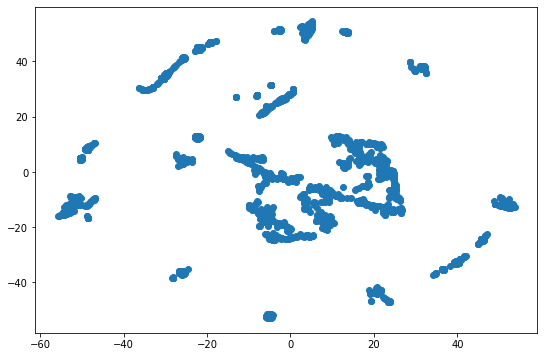

In [19]:
#TSNE(2) == StandardScaler( TSNE(2) )
# x, y = list(zip(*StandardScaler().fit_transform(TSNE(n_components=2, random_state=0).fit_transform(X_train[:1500]))))
x, y = list(zip(*(TSNE(n_components=2, random_state=0).fit_transform(X_train[:1500]))))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.show()

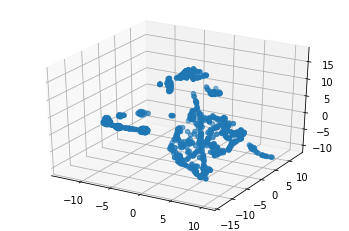

In [20]:
#TSNE(3)
data = TSNE(n_components=3, random_state=12).fit_transform(X_train[:900])
x, y, z = list(zip(*data))

fig = pylab.figure()
ax = fig.add_subplot(111, projection = '3d')
sc = ax.scatter(x,y,z)

In [21]:
# PCA(2) # little difference from StandardScaler vs MinMaxScaler
x, y = list(zip(*MinMaxScaler().fit_transform(PCA(2).fit_transform(X_train[:1500]))))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.show()

NameError: name 'StandardScaler' is not defined

In [ ]:
# PCA(3)
x, y, z = list(zip(*MinMaxScaler().fit_transform(PCA(3).fit_transform(X_train[:400]))))

fig = pylab.figure()
ax = fig.add_subplot(111, projection = '3d')
sc = ax.scatter(x,y,z)